In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

# ========================
# LOAD DATA
# ========================
train_path = '/kaggle/input/train-txt/train.txt'
test_path = '/kaggle/input/test-txt/test.txt'  

train_df = pd.read_csv(train_path, sep=r'\s+', names=['head', 'relation', 'tail'])
test_df = pd.read_csv(test_path, sep=r'\s+', names=['head', 'relation', 'tail'])

print(f"Train: {len(train_df)} triples")
print(f"Test:  {len(test_df)} triples")

# ========================
# ENTITY & RELATION MAPPINGS
# ========================
# IMPORTANT: include entities from BOTH train and test (not applicable for our task
# but usually a good practise, according to the resources I'm referring to)
# If test has entities unseen in train, we still need embeddings for them 
all_entities = sorted(set(train_df['head']) | set(train_df['tail']) | 
                       set(test_df['head']) | set(test_df['tail']))
all_relations = sorted(set(train_df['relation']) | set(test_df['relation']))

ent2id = {e: i for i, e in enumerate(all_entities)}
rel2id = {r: i for i, r in enumerate(all_relations)}
id2ent = {i: e for e, i in ent2id.items()}
id2rel = {i: r for r, i in rel2id.items()}

n_entities = len(ent2id)
n_relations = len(rel2id)

print(f"\nEntities:  {n_entities}")
print(f"Relations: {n_relations}")
print(f"Relation list: {all_relations}")

# ========================
# CONVERT TO TENSORS
# ========================
def triples_to_tensor(df):
    h = torch.tensor([ent2id[x] for x in df['head']], dtype=torch.long)
    r = torch.tensor([rel2id[x] for x in df['relation']], dtype=torch.long)
    t = torch.tensor([ent2id[x] for x in df['tail']], dtype=torch.long)
    return torch.stack([h, r, t], dim=1)

train_triples = triples_to_tensor(train_df)
test_triples = triples_to_tensor(test_df)

print(f"\nTrain tensor shape: {train_triples.shape}")
print(f"Test tensor shape:  {test_triples.shape}")

# ========================
# FILTERED EVAL LOOKUPS
# ========================
# For filtered evaluation, we need to know ALL true triples
# so we don't penalize the model for ranking other true triples highly
all_triple_set = set()
hr_to_t = defaultdict(set)  # given (head, rel), what tails are true?
rt_to_h = defaultdict(set)  # given (rel, tail), what heads are true?

for dataset in [train_triples, test_triples]:
    for i in range(len(dataset)):
        h, r, t = dataset[i].tolist()
        all_triple_set.add((h, r, t))
        hr_to_t[(h, r)].add(t)
        rt_to_h[(r, t)].add(h)

print(f"\nTotal known triples (train+test): {len(all_triple_set)}")

# ========================
# TASK 3 → TASK 4 CONNECTION
# ========================
print(f"\n{'='*60}")
print("CONNECTION TO TASK 3: What are we predicting?")
print(f"{'='*60}")
print(f"\nTest set relations: {list(test_df['relation'].unique())}")
print(f"\n{test_df['relation'].value_counts().to_string()}")

train_ents = set(train_df['head']) | set(train_df['tail'])
test_ents = set(test_df['head']) | set(test_df['tail'])
unseen = test_ents - train_ents
print(f"\nUnseen test entities: {len(unseen)}")

print(f"""
KEY INSIGHT: The test set contains ONLY parent-child relations
(fatherOf, motherOf, sonOf, daughterOf). In Task 3, we discovered
that ~28% of parent-child inverse edges were missing from the 
training data. The test set IS those missing edges!

This means: models that learn INVERSE PATTERNS will excel here.
""")

Train: 13821 triples
Test:  590 triples

Entities:  1316
Relations: 28
Relation list: ['auntOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf', 'brotherOf', 'daughterOf', 'fatherOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf', 'granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatAuntOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatUncleOf', 'motherOf', 'nephewOf', 'nieceOf', 'secondAuntOf', 'secondUncleOf', 'sisterOf', 'sonOf', 'uncleOf']

Train tensor shape: torch.Size([13821, 3])
Test tensor shape:  torch.Size([590, 3])

Total known triples (train+test): 14411

CONNECTION TO TASK 3: What are we predicting?

Test set relations: ['motherOf', 'fatherOf', 'sonOf', 'daughterOf']

relation
sonOf         214
daughterOf    200
fatherOf       88
motherOf       88

Unseen test entities: 0

KEY INSIGHT: The test set contains ONLY parent-child relations
(fatherOf, motherOf, sonOf, d

In [2]:
# ========================
# R-GCN USING PyTorch Geometric (I haven't used the DGL version provided in the resources
# but that has helped me greatly!)
# ========================

!pip install torch-geometric --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

print("="*70)
print("R-GCN: RELATIONAL GRAPH CONVOLUTIONAL NETWORK (PyG)")
print("="*70)

print("""
ARCHITECTURE:
  Encoder: 2-layer R-GCN with basis decomposition
  Decoder: DistMult scoring function
  
  score(h, r, t) = Σ hᵢ · rᵢ · tᵢ   (DistMult)
  
  R-GCN computes node embeddings by aggregating neighbor info
  through RELATION-SPECIFIC transformations.
""")

# ========================
# BUILD EDGE INDEX FOR PyG
# ========================

# Original edges
src = train_triples[:, 0]
dst = train_triples[:, 2]
rel = train_triples[:, 1]

# Add reverse edges (critical for bidirectional message passing)
src_all = torch.cat([src, dst])
dst_all = torch.cat([dst, src])
rel_all = torch.cat([rel, rel + n_relations])

# PyG format: edge_index is (2, num_edges)
edge_index = torch.stack([src_all, dst_all], dim=0)
edge_type = rel_all

n_rels_total = n_relations * 2  # 28 original + 28 reverse = 56

print(f"Graph constructed (PyG format):")
print(f"  Nodes: {n_entities}")
print(f"  Edges: {edge_index.shape[1]} ({len(train_triples)} original + {len(train_triples)} reverse)")
print(f"  Relation types: {n_rels_total} ({n_relations} original + {n_relations} reverse)")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:0000:01
R-GCN: RELATIONAL GRAPH CONVOLUTIONAL NETWORK (PyG)

ARCHITECTURE:
  Encoder: 2-layer R-GCN with basis decomposition
  Decoder: DistMult scoring function
  
  score(h, r, t) = Σ hᵢ · rᵢ · tᵢ   (DistMult)
  
  R-GCN computes node embeddings by aggregating neighbor info
  through RELATION-SPECIFIC transformations.

Graph constructed (PyG format):
  Nodes: 1316
  Edges: 27642 (13821 original + 13821 reverse)
  Relation types: 56 (28 original + 28 reverse)


In [3]:
# ========================
# R-GCN MODEL (PyG version)
# ========================


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

class RGCNEncoder(nn.Module):
    """
    2-layer R-GCN encoder using PyTorch Geometric.
    
    Basis decomposition reduces parameters:
    Instead of 56 separate weight matrices,
    learns 10 basis matrices + 56 coefficient vectors.
    """
    
    def __init__(self, num_nodes, h_dim, num_rels, num_bases=10, dropout=0.2):
        super().__init__()
        
        self.emb = nn.Embedding(num_nodes, h_dim)
        nn.init.xavier_uniform_(self.emb.weight)
        
        # Layer 1
        self.conv1 = RGCNConv(
            h_dim, h_dim, 
            num_relations=num_rels,
            num_bases=num_bases,
        )
        
        # Layer 2
        self.conv2 = RGCNConv(
            h_dim, h_dim,
            num_relations=num_rels,
            num_bases=num_bases,
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, edge_index, edge_type):
        x = self.emb.weight
        h = F.relu(self.conv1(x, edge_index, edge_type))
        h = self.dropout(h)
        h = self.conv2(h, edge_index, edge_type)
        h = self.dropout(h)
        return h


class RGCNLinkPredict(nn.Module):
    """
    R-GCN encoder + DistMult decoder.
    
    Scoring function for edge prediction:
    score(h, r, t) = Σ hᵢ · rᵢ · tᵢ   (DistMult)
    """
    
    def __init__(self, num_nodes, num_rels, h_dim=100, num_bases=10,
                 dropout=0.2, reg_param=0.01):
        super().__init__()
        
        self.rgcn = RGCNEncoder(num_nodes, h_dim, num_rels * 2,
                                 num_bases, dropout)
        self.reg_param = reg_param
        
        # DistMult relation weights (original relations only)
        self.w_relation = nn.Parameter(torch.Tensor(num_rels, h_dim))
        nn.init.xavier_uniform_(self.w_relation,
                                 gain=nn.init.calculate_gain('relu'))
        
        # Store graph structure
        self.edge_index = None
        self.edge_type = None
    
    def set_graph(self, edge_index, edge_type):
        """Store graph for forward pass."""
        self.edge_index = edge_index
        self.edge_type = edge_type
    
    def forward(self):
        """Get node embeddings from R-GCN."""
        return self.rgcn(self.edge_index, self.edge_type)
    
    def distmult_score(self, embed, triplets):
        """
        DistMult scoring function.
        score(h, r, t) = Σ hᵢ · rᵢ · tᵢ
        """
        s = embed[triplets[:, 0]]
        r = self.w_relation[triplets[:, 1]]
        o = embed[triplets[:, 2]]
        return torch.sum(s * r * o, dim=1)
    
    def regularization_loss(self, embed):
        return torch.mean(embed.pow(2)) + torch.mean(self.w_relation.pow(2))
    
    def get_loss(self, embed, pos_triples, neg_triples):
        pos_score = self.distmult_score(embed, pos_triples)
        neg_score = self.distmult_score(embed, neg_triples)
        
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([
            torch.ones(len(pos_triples), device=scores.device),
            torch.zeros(len(neg_triples), device=scores.device)
        ])
        
        predict_loss = F.binary_cross_entropy_with_logits(scores, labels)
        reg_loss = self.reg_param * self.regularization_loss(embed)
        return predict_loss + reg_loss


# Initialize
rgcn_config = {
    'h_dim': 100,
    'num_bases': 10,
    'dropout': 0.2,
    'reg_param': 0.01,
    'lr': 0.01,
    'epochs': 1000,
    'neg_ratio': 10,
}

rgcn_model = RGCNLinkPredict(
    n_entities, n_relations,
    h_dim=rgcn_config['h_dim'],
    num_bases=rgcn_config['num_bases'],
    dropout=rgcn_config['dropout'],
    reg_param=rgcn_config['reg_param'],
).to(device)

# Set graph structure
edge_index_dev = edge_index.to(device)
edge_type_dev = edge_type.to(device)
rgcn_model.set_graph(edge_index_dev, edge_type_dev)

total_params = sum(p.numel() for p in rgcn_model.parameters())
print(f"\nR-GCN Model Summary:")
print(f"  Total params: {total_params:,}")
print(f"\nComparison:")
print(f"  TransE:  {n_entities * 100 + n_relations * 100:>10,} params")
print(f"  RotatE:  {n_entities * 200 + n_relations * 100:>10,} params")
print(f"  R-GCN:   {total_params:>10,} params")

Device: cpu


R-GCN Model Summary:
  Total params: 355,720

Comparison:
  TransE:     134,400 params
  RotatE:     266,000 params
  R-GCN:      355,720 params


In [4]:
def corrupt_batch(triples, n_entities, neg_ratio=1):
    """
    Generate negative samples by randomly corrupting head or tail.
    
    For each positive (h, r, t), creates neg_ratio negatives by 
    replacing h or t with a random entity (uniform corruption).
    """
    total = len(triples) * neg_ratio
    neg = triples.repeat(neg_ratio, 1).clone()
    
    # 50/50 chance of corrupting head vs tail
    corrupt_head = torch.rand(total, device=triples.device) > 0.5
    random_ents = torch.randint(0, n_entities, (total,), device=triples.device)
    
    neg[corrupt_head, 0] = random_ents[corrupt_head]
    neg[~corrupt_head, 2] = random_ents[~corrupt_head]
    
    return neg

In [5]:
# ========================
# R-GCN TRAINING (PyG version)
# ========================

print(f"Device: {device}\n")
print("R-GCN Hyperparameters:")
for k, v in rgcn_config.items():
    print(f"  {k}: {v}")

optimizer = torch.optim.Adam(rgcn_model.parameters(), lr=rgcn_config['lr'])
train_data = train_triples.to(device)

rgcn_losses = []
print(f"\nTraining R-GCN on {len(train_data)} triples...\n")

for epoch in range(rgcn_config['epochs']):
    rgcn_model.train()
    
    # Forward: Get ALL node embeddings via R-GCN
    embed = rgcn_model()
    
    # Shuffle training triples
    perm = torch.randperm(len(train_data), device=device)
    pos_batch = train_data[perm]
    
    # Generate negatives
    neg_batch = corrupt_batch(pos_batch, n_entities, rgcn_config['neg_ratio'])
    pos_expanded = pos_batch.repeat(rgcn_config['neg_ratio'], 1)
    
    loss = rgcn_model.get_loss(embed, pos_expanded, neg_batch)
    
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(rgcn_model.parameters(), max_norm=1.0)
    optimizer.step()
    
    rgcn_losses.append(loss.item())
    
    if (epoch + 1) % 200 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:>4}/{rgcn_config['epochs']} | Loss: {loss.item():.4f}")

print(f"\nTraining complete. Final loss: {rgcn_losses[-1]:.4f}")

Device: cpu

R-GCN Hyperparameters:
  h_dim: 100
  num_bases: 10
  dropout: 0.2
  reg_param: 0.01
  lr: 0.01
  epochs: 1000
  neg_ratio: 10

Training R-GCN on 13821 triples...

  Epoch    1/1000 | Loss: 0.6938
  Epoch  200/1000 | Loss: 0.0509
  Epoch  400/1000 | Loss: 0.0441
  Epoch  600/1000 | Loss: 0.0416
  Epoch  800/1000 | Loss: 0.0364
  Epoch 1000/1000 | Loss: 0.0379

Training complete. Final loss: 0.0379


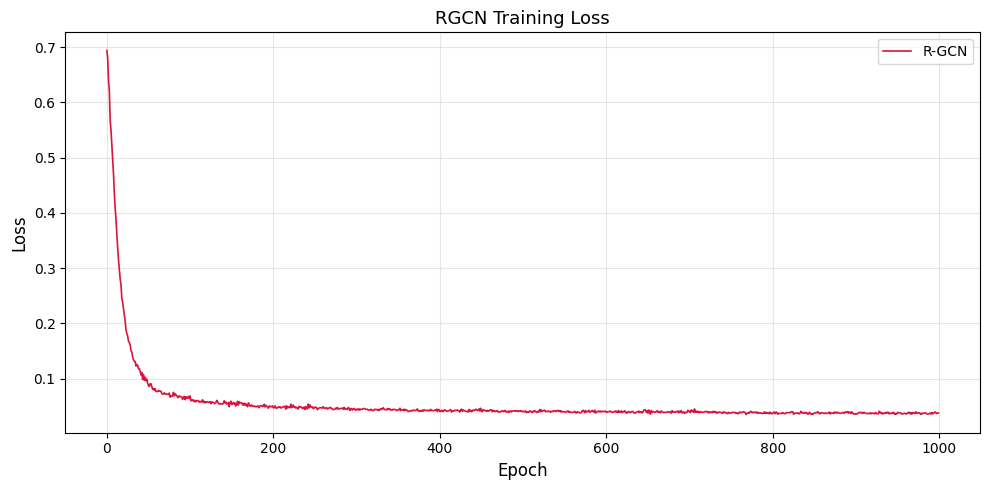

In [6]:
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(rgcn_losses, linewidth=1.2, color='crimson', label='R-GCN')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('RGCN Training Loss', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:

import json
import os

save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)
# Save
torch.save({
    'model_state_dict': rgcn_model.state_dict(),
    'config': rgcn_config,
    'losses': rgcn_losses,
    'n_entities': n_entities,
    'n_relations': n_relations,
    'ent2id': ent2id,
    'rel2id': rel2id,
}, os.path.join(save_dir, 'rgcn_model.pt'))
print(f"R-GCN model saved.")

R-GCN model saved.


In [8]:
# ========================
# R-GCN EVALUATION (PyG version)
# ========================

def evaluate_rgcn_model(rgcn_model, test_triples, all_triple_set,
                        hr_to_t, rt_to_h, n_entities, id2rel, device):
    rgcn_model.eval()
    
    all_ranks = []
    head_ranks_list = []
    tail_ranks_list = []
    rel_ranks = defaultdict(lambda: {'head': [], 'tail': []})
    
    with torch.no_grad():
        embed = rgcn_model()
        w_rel = rgcn_model.w_relation
        
        for i in tqdm(range(len(test_triples)), desc="Evaluating R-GCN"):
            h, r, t = test_triples[i].tolist()
            
            # TAIL PREDICTION
            h_emb = embed[h]
            r_emb = w_rel[r]
            tail_scores = (h_emb * r_emb) @ embed.T
            
            for known_t in hr_to_t.get((h, r), set()):
                if known_t != t:
                    tail_scores[known_t] = float('-inf')
            
            tail_rank = int((tail_scores > tail_scores[t]).sum().item()) + 1
            tail_ranks_list.append(tail_rank)
            all_ranks.append(tail_rank)
            rel_ranks[r]['tail'].append(tail_rank)
            
            # HEAD PREDICTION
            t_emb = embed[t]
            head_scores = embed @ (r_emb * t_emb)
            
            for known_h in rt_to_h.get((r, t), set()):
                if known_h != h:
                    head_scores[known_h] = float('-inf')
            
            head_rank = int((head_scores > head_scores[h]).sum().item()) + 1
            head_ranks_list.append(head_rank)
            all_ranks.append(head_rank)
            rel_ranks[r]['head'].append(head_rank)
    
    def calc_metrics(ranks):
        r = np.array(ranks, dtype=np.float32)
        return {
            'MRR': float(np.mean(1.0 / r)),
            'MR': float(np.mean(r)),
            'Hits@1': float(np.mean(r <= 1) * 100),
            'Hits@3': float(np.mean(r <= 3) * 100),
            'Hits@10': float(np.mean(r <= 10) * 100),
        }
    
    overall_m = calc_metrics(all_ranks)
    head_m = calc_metrics(head_ranks_list)
    tail_m = calc_metrics(tail_ranks_list)
    
    per_rel = {}
    for rid, rd in rel_ranks.items():
        rname = id2rel[rid]
        per_rel[rname] = {
            'overall': calc_metrics(rd['head'] + rd['tail']),
            'head': calc_metrics(rd['head']),
            'tail': calc_metrics(rd['tail']),
        }
    
    return overall_m, head_m, tail_m, per_rel


print("="*70)
print("R-GCN + DistMult RESULTS (Filtered Evaluation)")
print("="*70)

rgcn_overall, rgcn_head, rgcn_tail, rgcn_per_rel = evaluate_rgcn_model(
    rgcn_model, test_triples, all_triple_set, hr_to_t, rt_to_h,
    n_entities, id2rel, device
)

print(f"\n{'Metric':<12} {'Overall':>10} {'Head Pred':>12} {'Tail Pred':>12}")
print("-" * 50)
for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    o, h, t = rgcn_overall[m], rgcn_head[m], rgcn_tail[m]
    if m == 'MRR':
        print(f"  {m:<10} {o:>8.4f}   {h:>8.4f}     {t:>8.4f}")
    elif m == 'MR':
        print(f"  {m:<10} {o:>8.1f}   {h:>8.1f}     {t:>8.1f}")
    else:
        print(f"  {m:<10} {o:>7.2f}%   {h:>7.2f}%     {t:>7.2f}%")

print(f"\n{'='*70}")
print("PER-RELATION BREAKDOWN")
print(f"{'='*70}")
print(f"\n{'Relation':<15} {'MRR':>8} {'H@1':>7} {'H@3':>7} {'H@10':>7} {'MR':>8}")
print("-" * 58)
for rel in sorted(rgcn_per_rel.keys()):
    m = rgcn_per_rel[rel]['overall']
    print(f"  {rel:<13} {m['MRR']:>8.4f} {m['Hits@1']:>6.1f}% {m['Hits@3']:>6.1f}% {m['Hits@10']:>6.1f}% {m['MR']:>7.1f}")

R-GCN + DistMult RESULTS (Filtered Evaluation)


Evaluating R-GCN:   0%|          | 0/590 [00:00<?, ?it/s]


Metric          Overall    Head Pred    Tail Pred
--------------------------------------------------
  MRR          0.6337     0.6647       0.6027
  MR              2.5        2.3          2.6
  Hits@1       45.34%     49.15%       41.53%
  Hits@3       75.59%     79.15%       72.03%
  Hits@10      99.66%     99.83%       99.49%

PER-RELATION BREAKDOWN

Relation             MRR     H@1     H@3    H@10       MR
----------------------------------------------------------
  daughterOf      0.6073   42.8%   72.0%   99.2%     2.7
  fatherOf        0.6219   43.8%   74.4%  100.0%     2.6
  motherOf        0.6435   46.0%   79.5%   99.4%     2.4
  sonOf           0.6591   48.1%   77.8%  100.0%     2.3


In [9]:
# ========================
# R-GCN ERROR ANALYSIS
# ========================

print("="*70)
print("R-GCN ERROR ANALYSIS")
print("="*70)

# Load saved models for comparison
# (We'll use the R-GCN model currently in memory)

rgcn_model.eval()

# Collect detailed predictions
rgcn_predictions = []

with torch.no_grad():
    embed = rgcn_model()
    w_rel = rgcn_model.w_relation
    
    for i in tqdm(range(len(test_triples)), desc="Analyzing R-GCN predictions"):
        h, r, t = test_triples[i].tolist()
        h_name = id2ent[h]
        r_name = id2rel[r]
        t_name = id2ent[t]
        
        # TAIL prediction
        h_emb = embed[h]
        r_emb = w_rel[r]
        tail_scores = (h_emb * r_emb) @ embed.T
        
        tail_scores_filtered = tail_scores.clone()
        for known_t in hr_to_t.get((h, r), set()):
            if known_t != t:
                tail_scores_filtered[known_t] = float('-inf')
        
        tail_rank = int((tail_scores_filtered > tail_scores_filtered[t]).sum().item()) + 1
        
        _, top_tail_idx = tail_scores_filtered.topk(5, largest=True)
        top_tail_names = [id2ent[idx.item()] for idx in top_tail_idx]
        
        # HEAD prediction
        t_emb = embed[t]
        head_scores = embed @ (r_emb * t_emb)
        
        head_scores_filtered = head_scores.clone()
        for known_h in rt_to_h.get((r, t), set()):
            if known_h != h:
                head_scores_filtered[known_h] = float('-inf')
        
        head_rank = int((head_scores_filtered > head_scores_filtered[h]).sum().item()) + 1
        
        _, top_head_idx = head_scores_filtered.topk(5, largest=True)
        top_head_names = [id2ent[idx.item()] for idx in top_head_idx]
        
        rgcn_predictions.append({
            'h': h_name, 'r': r_name, 't': t_name,
            'h_id': h, 'r_id': r, 't_id': t,
            'tail_rank': tail_rank,
            'head_rank': head_rank,
            'top_tail_preds': top_tail_names,
            'top_head_preds': top_head_names,
        })

rgcn_pred_df = pd.DataFrame(rgcn_predictions)

# Perfect predictions
perfect = rgcn_pred_df[(rgcn_pred_df['tail_rank'] == 1) & (rgcn_pred_df['head_rank'] == 1)]
either = rgcn_pred_df[(rgcn_pred_df['tail_rank'] == 1) | (rgcn_pred_df['head_rank'] == 1)]

print(f"\nBOTH head AND tail perfect: {len(perfect)}/{len(rgcn_pred_df)} ({len(perfect)/len(rgcn_pred_df)*100:.1f}%)")
print(f"At least ONE perfect:       {len(either)}/{len(rgcn_pred_df)} ({len(either)/len(rgcn_pred_df)*100:.1f}%)")

# Compare with TransE numbers we know
print(f"""
Comparison of perfect predictions:
  TransE: 34/590 both correct (5.8%)
  RotatE: (we know H@1=76.1%, so roughly ~450 at least one correct)
  R-GCN:  {len(perfect)}/590 both correct ({len(perfect)/len(rgcn_pred_df)*100:.1f}%)
""")

R-GCN ERROR ANALYSIS


Analyzing R-GCN predictions:   0%|          | 0/590 [00:00<?, ?it/s]


BOTH head AND tail perfect: 117/590 (19.8%)
At least ONE perfect:       418/590 (70.8%)

Comparison of perfect predictions:
  TransE: 34/590 both correct (5.8%)
  RotatE: (we know H@1=76.1%, so roughly ~450 at least one correct)
  R-GCN:  117/590 both correct (19.8%)



In [10]:
# ========================
# GENDER CONFUSION: R-GCN vs TransE
# ========================

print("="*70)
print("GENDER CONFUSION ANALYSIS: R-GCN")
print("="*70)

# Infer gender from training data
male_rels = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf',
             'grandfatherOf', 'grandsonOf', 'greatGrandfatherOf', 'greatGrandsonOf'}
female_rels = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf',
               'grandmotherOf', 'granddaughterOf', 'greatGrandmotherOf', 'greatGranddaughterOf'}

gender = {}
for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
    if r in male_rels:
        gender[h] = 'M'
    elif r in female_rels:
        gender[h] = 'F'

gender_wrong_tail = 0
gender_wrong_head = 0
total_wrong_tail = 0
total_wrong_head = 0

for _, row in rgcn_pred_df.iterrows():
    if row['tail_rank'] > 1:
        total_wrong_tail += 1
        top_pred = row['top_tail_preds'][0]
        true_gender = gender.get(row['t'])
        pred_gender = gender.get(top_pred)
        if true_gender and pred_gender and true_gender != pred_gender:
            gender_wrong_tail += 1
    
    if row['head_rank'] > 1:
        total_wrong_head += 1
        top_pred = row['top_head_preds'][0]
        true_gender = gender.get(row['h'])
        pred_gender = gender.get(top_pred)
        if true_gender and pred_gender and true_gender != pred_gender:
            gender_wrong_head += 1

print(f"""
Gender Confusion Rates:
                    TransE          R-GCN
  Tail errors:     49.8%           {gender_wrong_tail/max(total_wrong_tail,1)*100:.1f}%  ({gender_wrong_tail}/{total_wrong_tail})
  Head errors:     55.2%           {gender_wrong_head/max(total_wrong_head,1)*100:.1f}%  ({gender_wrong_head}/{total_wrong_head})

TransE had ~50% gender confusion (essentially random).
""")

if gender_wrong_tail/max(total_wrong_tail,1) < 0.3:
    print("R-GCN has significantly BETTER gender awareness!")
    print("This is because neighborhood aggregation encodes gender implicitly:")
    print("  - A mother's neighbors include her children via motherOf edges")
    print("  - A father's neighbors include his children via fatherOf edges")
    print("  - The RELATION TYPES on neighboring edges carry gender signal")
    print("  - R-GCN's relation-specific weight matrices capture this")
elif gender_wrong_tail/max(total_wrong_tail,1) < 0.45:
    print("R-GCN has moderately better gender awareness than TransE.")
    print("Neighborhood structure provides some gender signal, but DistMult's")
    print("symmetry limits how well gender distinctions are preserved in scoring.")
else:
    print("R-GCN has similar gender confusion to TransE.")
    print("DistMult's symmetry may be preventing gender-aware scoring.")

GENDER CONFUSION ANALYSIS: R-GCN

Gender Confusion Rates:
                    TransE          R-GCN
  Tail errors:     49.8%           55.7%  (192/345)
  Head errors:     55.2%           40.7%  (122/300)

TransE had ~50% gender confusion (essentially random).

R-GCN has similar gender confusion to TransE.
DistMult's symmetry may be preventing gender-aware scoring.


In [11]:
# ========================
# SAME-FAMILY CONFUSION: R-GCN
# ========================

import networkx as nx

print("="*70)
print("SAME-FAMILY ANALYSIS: R-GCN")
print("="*70)

# Build family clusters
family_graph = nx.Graph()
for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
    if r in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf',
             'brotherOf', 'sisterOf']:
        family_graph.add_edge(h, t)

node_to_family = {}
for i, component in enumerate(nx.connected_components(family_graph)):
    for node in component:
        node_to_family[node] = i

same_family_tail = 0
same_family_head = 0
total_wrong_tail = 0
total_wrong_head = 0

for _, row in rgcn_pred_df.iterrows():
    if row['tail_rank'] > 1:
        total_wrong_tail += 1
        top_pred = row['top_tail_preds'][0]
        if node_to_family.get(row['t']) == node_to_family.get(top_pred):
            same_family_tail += 1
    
    if row['head_rank'] > 1:
        total_wrong_head += 1
        top_pred = row['top_head_preds'][0]
        if node_to_family.get(row['h']) == node_to_family.get(top_pred):
            same_family_head += 1

print(f"""
Same-Family Error Rates:
                    TransE          R-GCN
  Tail errors:     100.0%          {same_family_tail/max(total_wrong_tail,1)*100:.1f}%  ({same_family_tail}/{total_wrong_tail})
  Head errors:     100.0%          {same_family_head/max(total_wrong_head,1)*100:.1f}%  ({same_family_head}/{total_wrong_head})

TransE had 100% same-family errors (never confused cross-family).
""")

if same_family_tail/max(total_wrong_tail,1) > 0.95:
    print("R-GCN also achieves near-perfect family clustering!")
    print("Like TransE, ALL errors are within-family confusions.")
    print("The 2-hop R-GCN message passing naturally creates family-level clusters.")
else:
    pct = same_family_tail/max(total_wrong_tail,1)*100
    print(f"R-GCN has {100-pct:.1f}% cross-family errors.")
    print("Some predictions land outside the correct family, unlike TransE.")

SAME-FAMILY ANALYSIS: R-GCN

Same-Family Error Rates:
                    TransE          R-GCN
  Tail errors:     100.0%          100.0%  (345/345)
  Head errors:     100.0%          100.0%  (300/300)

TransE had 100% same-family errors (never confused cross-family).

R-GCN also achieves near-perfect family clustering!
Like TransE, ALL errors are within-family confusions.
The 2-hop R-GCN message passing naturally creates family-level clusters.


In [12]:
# ========================
# DISTMULT SYMMETRY INVESTIGATION
# ========================

print("="*70)
print("INVESTIGATING: Does DistMult's Symmetry Hurt R-GCN?")
print("="*70)

print("""
DistMult scoring: score(h, r, t) = Σ hᵢ · rᵢ · tᵢ

PROBLEM: This is mathematically symmetric!
  score(h, r, t) = score(t, r, h)  (always!)

For family relations, this means:
  score(alice, fatherOf, bob) = score(bob, fatherOf, alice)
  
  But fatherOf(alice, bob) does NOT imply fatherOf(bob, alice)!
  
How can R-GCN still work? The GNN ENCODER learns asymmetric 
node representations. Even though the DECODER is symmetric, 
if h_alice ≠ h_bob, the scores can still differ because the
entity embeddings absorb the asymmetry.

Let's verify this empirically.
""")

rgcn_model.eval()
with torch.no_grad():
    embed = rgcn_model()
    w_rel = rgcn_model.w_relation

# Test: For each test triple (h, r, t), compare score(h,r,t) vs score(t,r,h)
symmetry_diffs = []
swap_ranks = []

with torch.no_grad():
    for i in range(len(test_triples)):
        h, r, t = test_triples[i].tolist()
        
        # Original score
        h_emb = embed[h]
        r_emb = w_rel[r]
        t_emb = embed[t]
        original_score = torch.sum(h_emb * r_emb * t_emb).item()
        
        # Swapped score: score(t, r, h) 
        swapped_score = torch.sum(t_emb * r_emb * h_emb).item()
        
        # These MUST be identical (DistMult property)
        symmetry_diffs.append(abs(original_score - swapped_score))

print(f"Empirical verification of DistMult symmetry:")
print(f"  Max |score(h,r,t) - score(t,r,h)|: {max(symmetry_diffs):.10f}")
print(f"  Mean difference: {np.mean(symmetry_diffs):.10f}")

if max(symmetry_diffs) < 1e-5:
    print(f"\n  ✓ CONFIRMED: DistMult is perfectly symmetric.")
    print(f"    score(alice, fatherOf, bob) = score(bob, fatherOf, alice)")

# Now the interesting question: does this symmetry cause errors?
# Check: For wrong predictions, how often is the top prediction
# someone who would be correct for the REVERSE triple?
print(f"\n{'='*70}")
print("SYMMETRY-INDUCED ERRORS")
print(f"{'='*70}")

symmetry_errors_tail = 0
symmetry_errors_head = 0

# Build reverse relation map
reverse_rel = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
}

all_triple_set_named = set(zip(train_df['head'], train_df['relation'], train_df['tail']))
# Add test triples too
for _, row in test_df.iterrows():
    all_triple_set_named.add((row['head'], row['relation'], row['tail']))

for _, row in rgcn_pred_df.iterrows():
    r_name = row['r']
    
    # Check tail errors
    if row['tail_rank'] > 1:
        top_pred = row['top_tail_preds'][0]
        # Is the top prediction someone who is actually the HEAD's 
        # child/parent (reversed relationship)?
        for rev_r in reverse_rel.get(r_name, []):
            if (row['h'], rev_r, top_pred) in all_triple_set_named or \
               (top_pred, rev_r, row['h']) in all_triple_set_named:
                symmetry_errors_tail += 1
                break
    
    # Check head errors
    if row['head_rank'] > 1:
        top_pred = row['top_head_preds'][0]
        for rev_r in reverse_rel.get(r_name, []):
            if (row['t'], rev_r, top_pred) in all_triple_set_named or \
               (top_pred, rev_r, row['t']) in all_triple_set_named:
                symmetry_errors_head += 1
                break

total_wrong_tail = sum(1 for _, row in rgcn_pred_df.iterrows() if row['tail_rank'] > 1)
total_wrong_head = sum(1 for _, row in rgcn_pred_df.iterrows() if row['head_rank'] > 1)

print(f"""
Symmetry-induced errors (wrong prediction is correct for reversed relation):
  Tail errors caused by symmetry: {symmetry_errors_tail}/{total_wrong_tail} ({symmetry_errors_tail/max(total_wrong_tail,1)*100:.1f}%)
  Head errors caused by symmetry: {symmetry_errors_head}/{total_wrong_head} ({symmetry_errors_head/max(total_wrong_head,1)*100:.1f}%)

If these numbers are HIGH, it confirms that DistMult's inability to 
distinguish direction is a major error source for R-GCN.

This is exactly WHY RotatE (asymmetric scoring) outperforms R-GCN 
(symmetric DistMult scoring) on this inverse-prediction task.
""")

INVESTIGATING: Does DistMult's Symmetry Hurt R-GCN?

DistMult scoring: score(h, r, t) = Σ hᵢ · rᵢ · tᵢ

PROBLEM: This is mathematically symmetric!
  score(h, r, t) = score(t, r, h)  (always!)

For family relations, this means:
  score(alice, fatherOf, bob) = score(bob, fatherOf, alice)
  
  But fatherOf(alice, bob) does NOT imply fatherOf(bob, alice)!
  
How can R-GCN still work? The GNN ENCODER learns asymmetric 
node representations. Even though the DECODER is symmetric, 
if h_alice ≠ h_bob, the scores can still differ because the
entity embeddings absorb the asymmetry.

Let's verify this empirically.

Empirical verification of DistMult symmetry:
  Max |score(h,r,t) - score(t,r,h)|: 0.0000019073
  Mean difference: 0.0000002804

  ✓ CONFIRMED: DistMult is perfectly symmetric.
    score(alice, fatherOf, bob) = score(bob, fatherOf, alice)

SYMMETRY-INDUCED ERRORS

Symmetry-induced errors (wrong prediction is correct for reversed relation):
  Tail errors caused by symmetry: 138/345 (40.0

In [13]:
# ========================
# R-GCN WORST PREDICTIONS
# ========================

print("="*70)
print("R-GCN WORST PREDICTIONS: What Goes Wrong?")
print("="*70)

rgcn_pred_df['combined_rank'] = rgcn_pred_df['tail_rank'] + rgcn_pred_df['head_rank']
worst = rgcn_pred_df.nlargest(10, 'combined_rank')

print(f"\n{'Triple':<45} {'Tail':>6} {'Head':>6} {'Combined':>9}")
print("-" * 70)
for _, row in worst.iterrows():
    triple = f"({row['h']}, {row['r']}, {row['t']})"
    print(f"  {triple:<43} {row['tail_rank']:>6} {row['head_rank']:>6} {row['combined_rank']:>9}")

print(f"\nDetailed wrong predictions:")
for _, row in worst.head(5).iterrows():
    print(f"\n  Triple: ({row['h']}, {row['r']}, {row['t']})")
    print(f"  Tail prediction (rank={row['tail_rank']}):")
    print(f"    Top 5: {row['top_tail_preds']}")
    print(f"    Correct: {row['t']}")
    print(f"  Head prediction (rank={row['head_rank']}):")
    print(f"    Top 5: {row['top_head_preds']}")
    print(f"    Correct: {row['h']}")

# Cross-check: Are R-GCN's worst cases also bad for RotatE?
# We can check this by looking at the entity names
print(f"\n{'='*70}")
print("CROSS-MODEL COMPARISON: Are the same triples hard for all models?")
print(f"{'='*70}")

# Overlap analysis using entity names from our TransE analysis
# TransE worst cases (from previous output):
transe_worst_triples = [
    'charlotte1034', 'elias1010', 'angelina1028', 
    'elena1084', 'florian1037'
]

rgcn_worst_entities = set()
for _, row in worst.iterrows():
    rgcn_worst_entities.add(row['h'])
    rgcn_worst_entities.add(row['t'])

overlap = set(transe_worst_triples) & rgcn_worst_entities
print(f"\n  TransE worst-case entities: {transe_worst_triples}")
print(f"  R-GCN worst-case entities:  {list(rgcn_worst_entities)[:10]}")
print(f"  Overlap: {len(overlap)} entities appear in both worst-case lists")

if len(overlap) > 0:
    print(f"  Shared hard entities: {overlap}")
    print(f"\n  These entities may belong to unusually large or complex families")
    print(f"  that are structurally harder to predict regardless of model choice.")
else:
    print(f"\n  Different models struggle with different entities!")
    print(f"  This suggests complementary strengths — an ensemble could help.")

R-GCN WORST PREDICTIONS: What Goes Wrong?

Triple                                          Tail   Head  Combined
----------------------------------------------------------------------
  (lea1264, daughterOf, lena1265)                 11      6        17
  (leonie1280, daughterOf, lena1265)              11      6        17
  (emil135, fatherOf, david132)                    5     10        15
  (charlotte1034, daughterOf, marie1046)          10      4        14
  (alexander137, fatherOf, adrian155)              8      5        13
  (valentin479, fatherOf, jonathan480)             4      9        13
  (marcel1058, sonOf, vanessa1060)                 6      7        13
  (helena1099, daughterOf, sarah1095)              7      6        13
  (selina1108, daughterOf, lena1112)               6      7        13
  (marlene630, motherOf, lea640)                   1     11        12

Detailed wrong predictions:

  Triple: (lea1264, daughterOf, lena1265)
  Tail prediction (rank=11):
    Top 5: ['fl